tensor([0.1411], grad_fn=<SinBackward0>)
tensor([-0.9900])


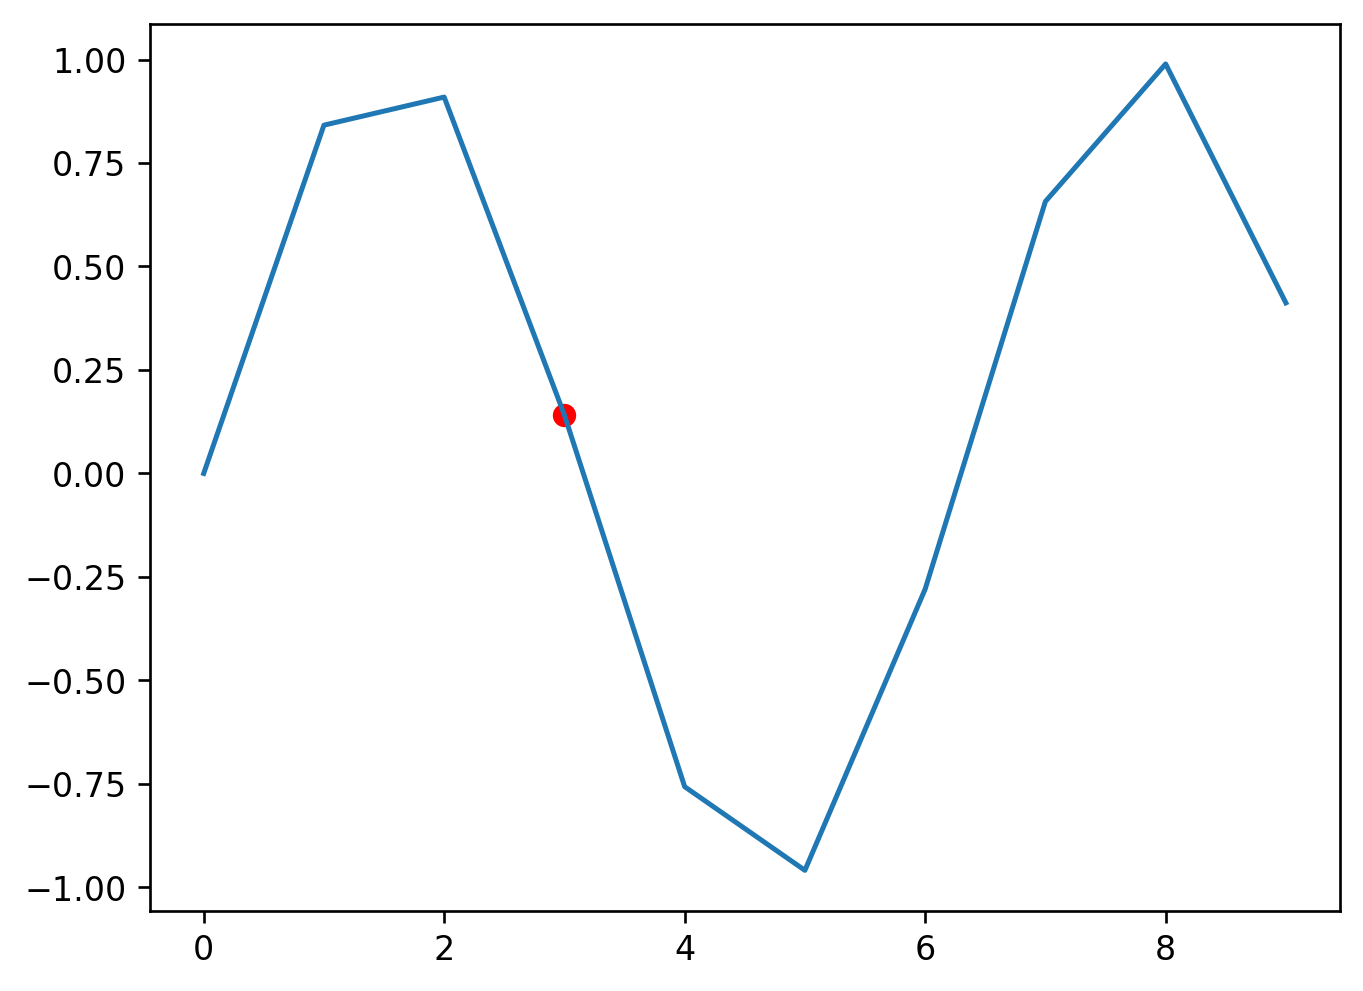

In [90]:
import torch 
import matplotlib.pyplot as plt

#x = torch.arange(0.0,10.0)

x = torch.tensor([3.0], requires_grad=True)
y = torch.sin(x) # Forward pass

y.backward() # Backward pass
x.grad

plt.plot(x.detach().numpy(), y.detach().numpy(), 'ro')
plt.plot(torch.arange(0.0,10.0).detach().numpy(),torch.sin(torch.arange(0.0,10.0)).detach().numpy())


print(y)
print(x.grad)

In [1]:
import pickle
from typing import Callable, List, Tuple

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

from utils import plot_throw2

# set jupyter configurations
%matplotlib inline
%config InlineBackend.figure_format='retina'
default_dpi = mpl.rcParamsDefault["figure.dpi"]
mpl.rcParams["figure.dpi"] = default_dpi * 1.2

## Simulator: Throwing a ball in air

A ballistic throw in air is modelled via a differential equation:

$\frac{d}{dt} x = v_x$

$a_x\frac{d}{dt} v_x = -\frac{k}{m} \cdot v_x \cdot s$

$\frac{d}{dt} z = v_z$

$a_z\frac{d}{dt} v_z = -\frac{k}{m} \cdot v_z \cdot s - g$

Here, $g$ is the gravitational acceleration, $k$ is the drag constant, $m$ is the mass of the object and $s=|v|= \sqrt{v_x^2 + v_z^2}$.


In [2]:
def throw(
    speed: float,
    angle: int,
    drag: float,
    r: float = 0.050,
    m: float = 0.2,
    h_noise: float = 3.0,
    ρ: float = 1.225,
    g: float = 9.81,
) -> dict:
    """Simulate the throw of a ball.
    
    Following https://scipython.com/book2/chapter-8-scipy/examples/a-projectile-with-air-resistance/
    
    Args:
        speed: magnitude of initial speed (m/s).
        angle: launch angle with horizontal (degrees)
        drag: drag coefficient
        r: projectile radius (m)
        m: projectile mass (kg)
        h_noise: std of measurements of altitude (m)
        ρ: air density (default is at sea surface, 15C)
        g: gravitational acceleration (default is average at surface of Earth)
    
    Returns:
        simulation: simulation results containing distance travelled
            and height as a function of time.
    """

    k = 0.5 * drag * ρ * (np.pi * r**2)  # drag constant, proportional to area

    def deriv(t, u):
        """Return right-hand side of ODE system for the throw."""
        # see diagram at e.g. http://www.physics.smu.edu/fattarus/ballistic.html

        x, v_x, z, v_z = u
        speed = np.hypot(v_x, v_z)
        a_x, a_z = -k / m * speed * v_x, -k / m * speed * v_z - g

        return v_x, a_x, v_z, a_z

    # position and velocity components at launch
    x0, z0 = 0, 0
    rad_angle = np.radians(angle)
    v0_x, v0_z = speed * np.cos(rad_angle), speed * np.sin(rad_angle)

    # integration grid
    t = np.linspace(0, 400, 4000)

    # solve initial value problem (ivp) for distance traveled(t) and height(t)
    solution = solve_ivp(
        deriv, t_span=(t[0], t[-1]), y0=(x0, v0_x, z0, v0_z), dense_output=True
    )  # dense => continuous solution

    # evaluate solution to obtain distance and height at each time point
    d, _, h, _ = solution.sol(t)

    # the simulator always uses the same time grid, interpolate to the same distance grid
    f = interp1d(d, h, bounds_error=False)

    d_target = np.linspace(0, 150, 100)

    h_target = f(d_target)

    # add noise to make the process stochastic
    x = h_target + h_noise * np.random.randn(d_target.shape[0])

    # to obtain the params from the interactive plot, we need to return parameters here as well
    return dict(θ=(speed, angle, drag, r, m, h_noise, ρ, g), d=d_target, x=x)

If you run the cell below with throwing speed 40 m/s, angle 30 degrees and drag coefficient 0.13, you obtain circles that directly overlay $x_o$ (i.e., the original simulation).

<Axes: title={'center': 'MSE: 230.78'}, xlabel='Distance traveled (m)', ylabel='Height (m)'>

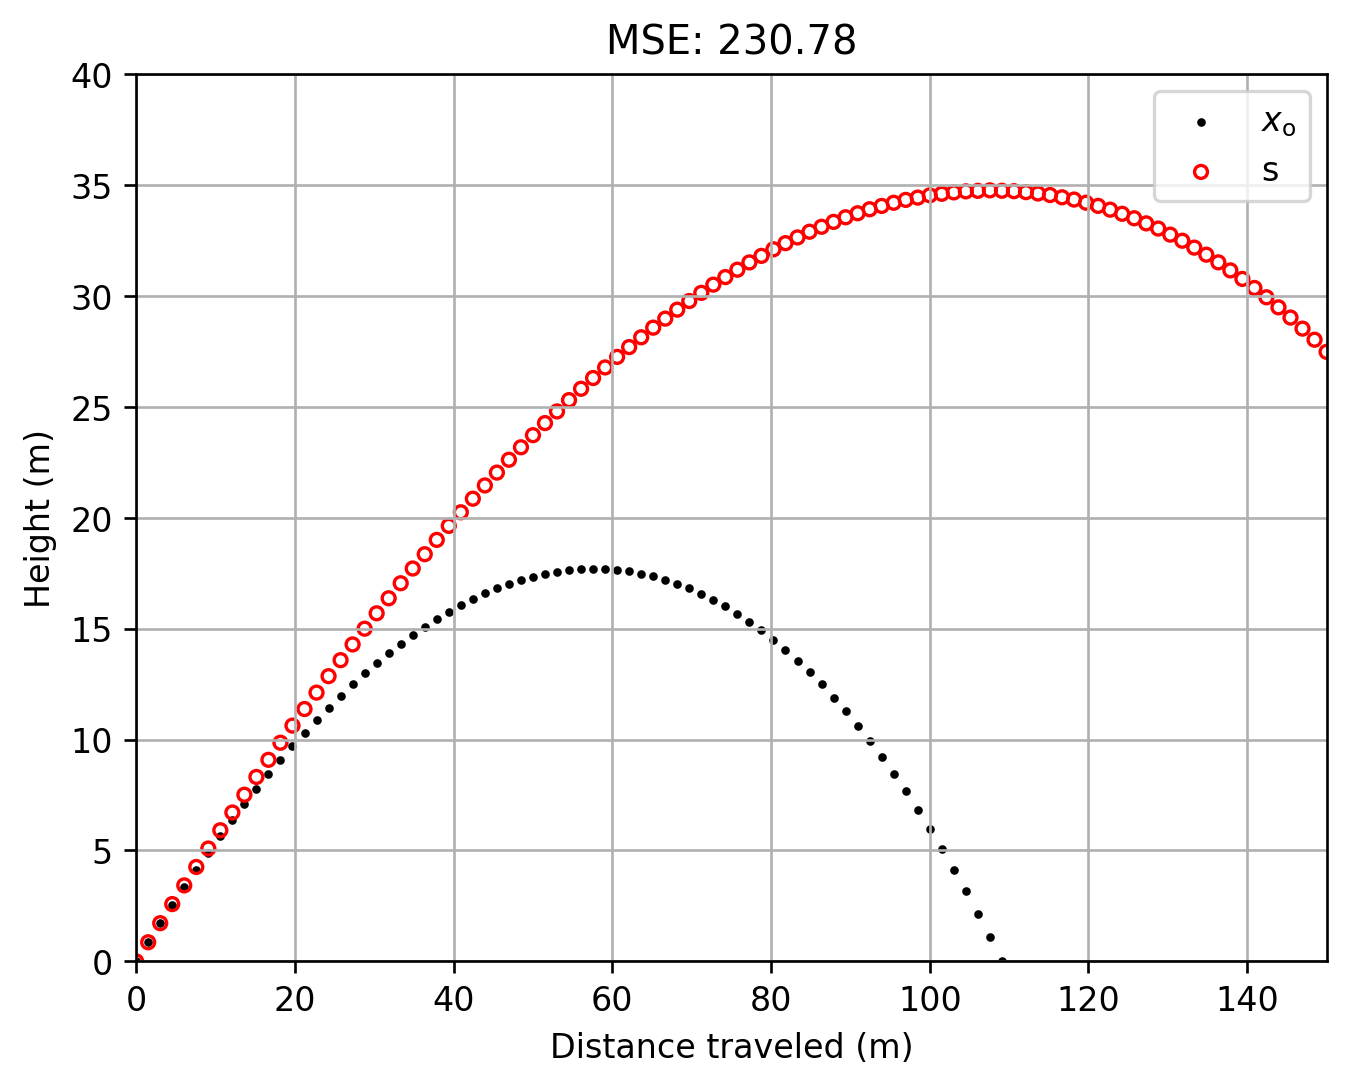

In [3]:
with open("throw-x_o-1.pickle", "rb") as f:
    d_o, x_o = pickle.load(f)

sim = throw(60, 30, 0.13, h_noise=0)  # run the simulation without noise

d, x = sim["d"], sim["x"]

plot_throw2(d_o, x_o, d, x)

a) Familiarize yourself with the simulator by running it with different parameter settings for speed, angle and drag.

b) Find a different parameter set than the original parameter set (speed 40 m/s, angle 30 degrees and drag 0.13) that gives you the same final distance traveled. This online simulator can help you: http://www.physics.smu.edu/fattarus/ballistic.html

1. When models have different parameter sets that give the same solution, we say that the models show degeneracy (or that they have degenerate solutions).
2. This is a property of many models in natural sciences (e.g., Physics, Biology...), and is the subject of active research: e.g., how to analytically or numerically find these degenerate solutions, or what these degenerate solutions mean about the reality they are modelling.

Imagine you can only observe a noisy version of the data, because you can only measure the height imprecisely. We simulated this by adding independent Gaussian noise.

Try to find out which parameters were used to generate the simulation by manually adjusting the parameters. Try to find a solution with $MSE<20$.

Bonus question: What is the minimum MSE that you can achieve given that the measurements are noisy?

What do you think were the original parameters?

## Implement rejection-ABC

We will implement an algorithm called rejection ABC to make this inference automatic. For this, you need:
* The simulator (implemented above)
* A distance function (in `distance`)
* A threshold $\epsilon$ for what we accept as "close to the observation"
* A prior over the parameters (we start with a uniform prior)
* A function to generate simulations from the prior (in `random_simulation`)
* A loop that generates simulations but only keeps them if they are closer than $\epsilon$ (in `rejection_abc`)

In [4]:
def distance(x1: np.array, x2: np.array, d_func: Callable) -> float:
    """Returns distance according to specified distance measure.

    Args:
        y1, y2: y-values (important: need to be sampled at fixed x-grid so that point in y match!)
        d_func: distance function (symmetric)

    Returns:
        distance between prediction and data.
    """
    
    #### INSERT YOUR CODE HERE ####
    return d_func(x1[x1 > 0], x2[x1 > 0])
    #### ##################### ####


# choose a distance function ... 
mse = lambda x1, x2: np.mean((x1 - x2)**2)
#### #####################

In [5]:
def random_simulation(
    prior_speed: Tuple[float, float], prior_angle: Tuple[float, float]
) -> Tuple[float, float, float]:
    """Return simulation results from uniformly sampled parameters."""
    U = np.random.uniform

    speed = U(*prior_speed)
    angle = U(*prior_angle)
    drag = 0.13

    simulation = throw(speed, angle, drag)

    return simulation["d"], simulation["x"], simulation["θ"]

In [8]:
def rejection_abc(
    x_o: np.array,
    distance_function: Callable = mse,
    eps: float = 30,
    n_samples: int = 50,
    prior_speed: Tuple[float, float] = (10, 60),
    prior_angle: Tuple[float, float] = (10, 70),
) -> Tuple[List, int]:
    """Return list of parameters such that distance of simulation x to x_o is <= ε.

    Args:
        eps: acceptance threshold
        distance_function: function to compute distance between prediction and observation
        n_samples: desired number of accepted parameter samples
                   (aalternatively, you can cap the number of simulations and check how many
                    acceptances you get*)
    Return:
        θ_accepted (list) : list of tuples with accepted parameters
        sim_no (int) : number of simulations that were needed

    """
    θ_accepted = []
    sim_no = 0
    while len(θ_accepted) < n_samples:
        sim_no += 1
        
        ###
        d, x, θ = random_simulation(prior_speed, prior_angle)
        

        if (distance(x_o, x, distance_function) < eps):
            θ_accepted.append(θ[0:3])
        ####

    θ_accepted = np.vstack(θ_accepted)
    return θ_accepted, sim_no

NameError: name 'θ' is not defined

In [13]:
# load the data with unknown parameters
with open("throw-x_o-2.pickle", "rb") as f:
    d_o, x_o = pickle.load(f)

# run rejection abc
prior_speed = (10, 70)
prior_angle = (10, 60)
θ, sim_no = rejection_abc(x_o, eps=50, prior_speed=prior_speed, prior_angle=prior_angle)

What fraction of randomly sampled simulations lead to accepted parameter sets? 

In [8]:
# ADD YOUR COMPUTATION HERE

Now, plot some of the accepted simulations. By changing the index variable, you can look at different accepted simulations.

<Axes: title={'center': 'MSE: 22.63'}, xlabel='Distance traveled (m)', ylabel='Height (m)'>

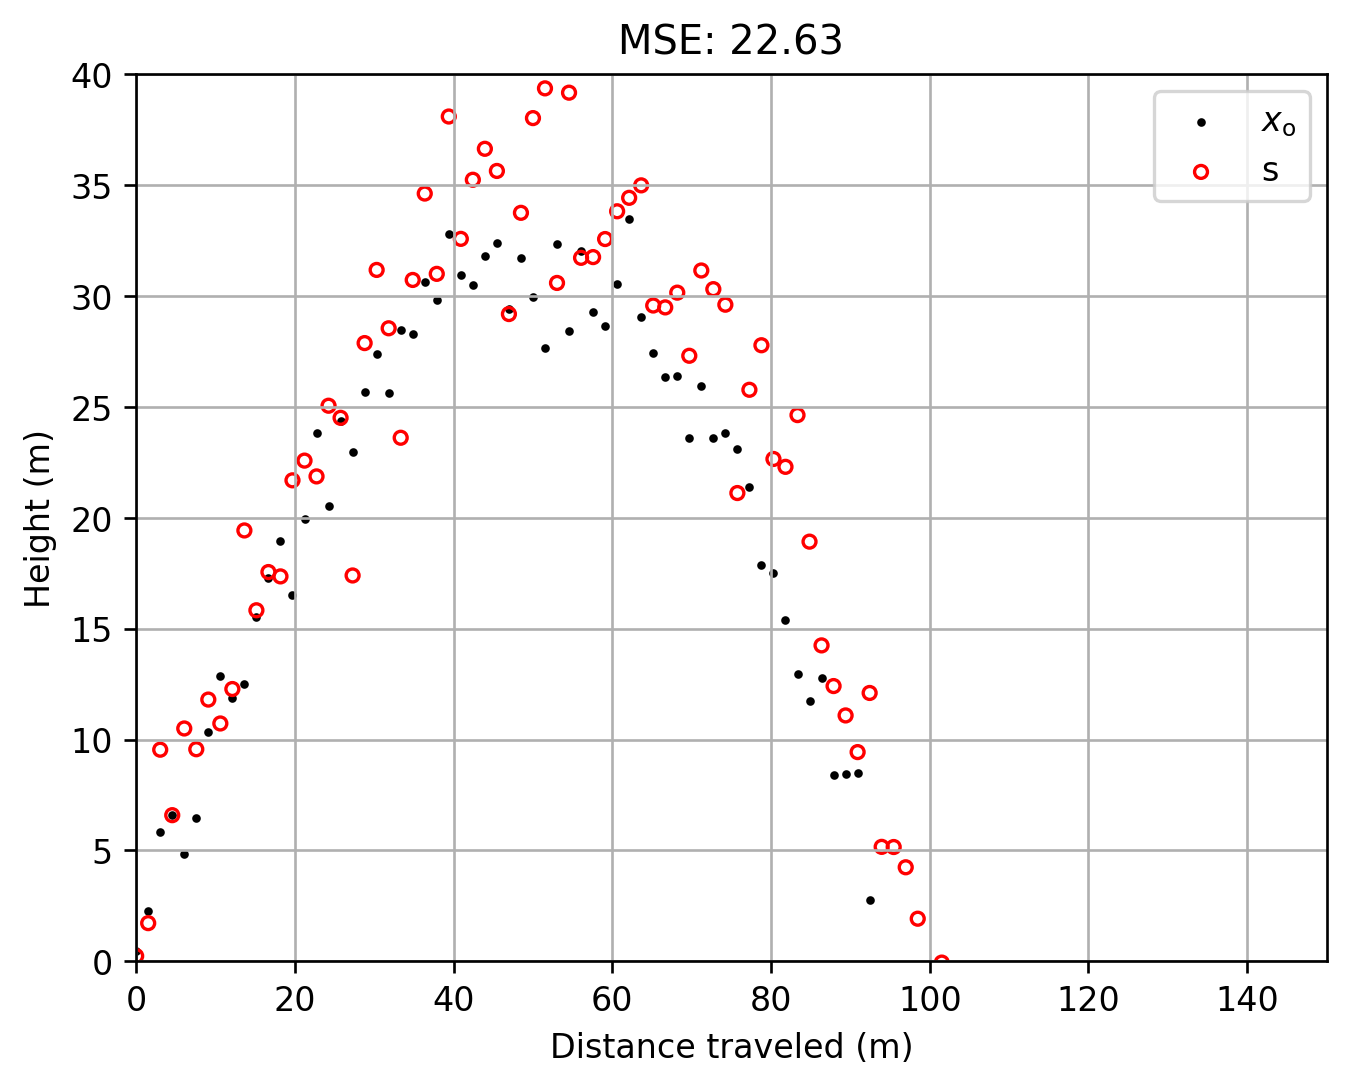

In [14]:
idx = 2

velocity, angle, drag = θ[idx]
sim = throw(velocity, angle, drag)  # run the simulation with noise

d, x = sim["d"], sim["x"]

plot_throw2(d_o, x_o, d, x)

Let's look at a plot of the accepted samples compared to samples from the prior. The size of the plot is the range of all generated samples based on the uniform prior. The red square marks the mean of the accepted samples:

In [15]:
import torch
from sbi.analysis import pairplot

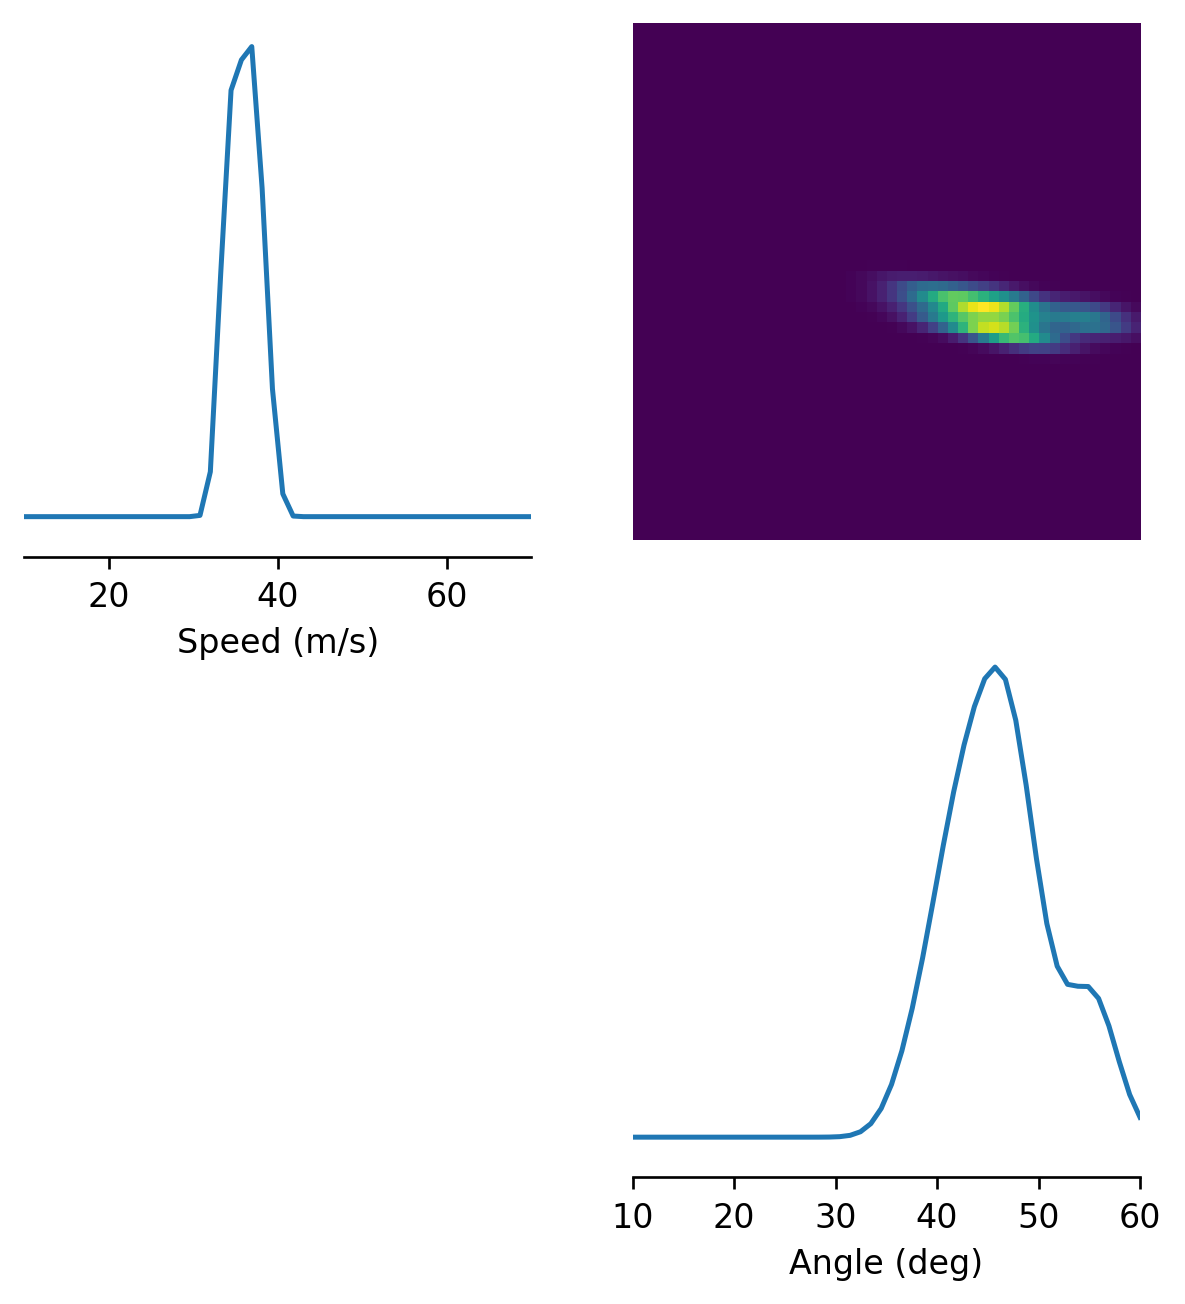

In [16]:
_ = pairplot(
    torch.from_numpy(θ[:, 0:2]),
    figsize=(6, 6),
    labels=["Speed (m/s)", "Angle (deg)"],
    points=[],
    points_colors=("orange",),
    limits=np.array([prior_speed, prior_angle]),
    diag="kde",
    upper="kde",
)

The true speed was 35 m/s and the true angle 50 degrees. Intepret the plot above. 

The speed of rejection ABC is determined by the fraction of samples accepted. Explore how changing $\epsilon$ or the prior can change the fraction of accepted samples and the spread of the points in the above plot.